# An application of Bayesian regression in visual neurosicence: modeling the relationship between receptive field size and eccentricity

### by Hsin-Hao Yu
Department of Physiology, Monash University

**Background:**
In studies of natural phenomena, if two measured quantities are observed to be in a systematic relationship, very often we want to know if this relationship is affected by a certain manipulation. This is a basic form of statistical inferencing that has found many applications in scientific and clinical research.

In a recent paper published in _The Journal of Neuroscience_ ([Hadjidimitrakis et al., 2019](https://www.jneurosci.org/content/39/27/5311.abstract)), I was asked to perform this type of analysis for a dataset collected in the visual cortex. I solved this problem with Model II regression and an ad hoc permutation test, and was able to establish that the power law that governed his data was dependent on the site where the data was collected. Although I got the job done, I was not fully satisfied with it, because all that it did was producing a p-value. I’d be happier if all the questions that neuroscientists want to know about in this dataset could be answered within a unified framework.

Soon after I finished this analysis, a biostatistician friend introduced me to JAGS and STAN. They are powerful and flexible packages that really make Bayesian inferencing accessible. As I was reading about them, I realized that the Bayesian approach is the right way to go for analyzing the power law of receptive field size in the visual cortex. Since this is a fundamental question in visual neuroscience, I decided to re-visit this dataset. A journal publication is being prepared.

**The scientific question:** In the visual cortex, the receptive field (RF) of a neuron is the region in the visual field where a stimulus can evoke the neuron to respond. Importantly, in the cortex of highly visual animals, the size of the RF is dependent on its distance to the fovea - a measurement called _eccentricity_. This relationship has profound implications in the overall architecture of the visual system. The visual cortex consists of many "modules" called _areas_. Comparing RF size across multiple areas provides important clues about their functions, and can inform the identification of visual areas. Unfortunately, a rigorous framework for this comparison has not been  established. With the recent popularity of measuring "population RF" in functional imaging, RF data are becoming abundant, which makes RF quantification and comparison a more pressing issue.

**Objectives:**  The goal of this notebook is to show that Bayesian regression provides a unified framework for analyzing the relationship between RF size and eccentricity, and can be implemented easily with R and modern Bayesian packages such as [JAGS](http://mcmc-jags.sourceforge.net) and [STAN](https://mc-stan.org). 

More specifically, I will show how to perform the following analyses the Bayesian way:

1. Estimate the parameters of the RF size/eccentricity relationship, while taking into account the uncertainty of eccentricity measures (Type II regression)
2. Decide the most parsimonious form of the relationship using Bayesian model section, and
3. Characterize the differences of this relationship in two (or more) areas, using the Bayesian form of ANCOVA.

## Import libraries

In [1]:
library(tidyverse)    # for data manipulation
library(patchwork)    # for composing figures

library(lmodel2)      # for model II regression
library(R2jags)       # for Bayesian analysis via JAGS
library(runjags)      # for Bayesian analysis via JAGS
library(broom.mixed)  # for tidying MCMC results

Registered S3 methods overwritten by 'ggplot2':
  method         from 
  [.quosures     rlang
  c.quosures     rlang
  print.quosures rlang
Registered S3 method overwritten by 'rvest':
  method            from
  read_xml.response xml2
── Attaching packages ─────────────────────────────────────── tidyverse 1.2.1 ──
✔ ggplot2 3.1.1     ✔ purrr   0.3.2
✔ tibble  3.0.5     ✔ dplyr   1.0.3
✔ tidyr   1.1.2     ✔ stringr 1.4.0
✔ readr   1.3.1     ✔ forcats 0.4.0
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
Loading required package: rjags
Warning message:
“package ‘rjags’ was built under R version 3.6.3”Loading required package: coda
Warning message:
“package ‘coda’ was built under R version 3.6.3”Linked to JAGS 4.3.0
Loaded modules: basemod,bugs

Attaching package: ‘R2jags’

The following object is masked from ‘package:coda’:

    traceplot


Attaching package: ‘runjags’

The follo

Tell Jupyter to make the figures smaller:

In [2]:
options(repr.plot.width=6, repr.plot.height=3)

## Load and preprocess data
This is the data used in Figure 10 in Hadjidimitrakis et al. (2019), which provides RF size and eccentricity information for neurons recorded in two areas (area V2 and V6) of the macaque visual cortex. The dataset divides V6 RFs into the upper and the lower visual fields (`tmp.data.V6UVF` and `tmp.data.V6LVF`), but for the purpose of this notebook, we'll pool them together

The csv files don't have headers so I have to add the column names myself. Also add a new column to indicate the cortical area where the data were collected:

In [3]:
read.data <- function (filename, area.name){
    data <- read.csv(filename, header=FALSE)
    names(data)<-c("ecc","rfsize")
    data <- data %>% mutate(area=area.name)
    return (data)
}

In [4]:
tmp.data.V2 <- read.data("../2021-bayes/2019-kostas/data/V2.csv", "V2")
tmp.data.V6UVF <- read.data("../2021-bayes/2019-kostas/data/UVF_V6.csv", "V6+")
tmp.data.V6LVF <- read.data("../2021-bayes/2019-kostas/data/LVF_V3_V6.csv", "V6-")

Combine the 3 individual data sets into one data frame:

In [5]:
data <- rbind(tmp.data.V2, tmp.data.V6UVF, tmp.data.V6LVF)

We are going to ignore the difference between "V6+" and "V6-", so they are aggregated into a single label called "V6" in a new column. `dplyr`'s `mutat()` function is used to add a new column `aggr.area` based on `area`:

In [6]:
data <- data %>% mutate(aggr.area=ifelse(area=="V2", "V2", "V6"))

We'll work in log scale a lot, so we'll create new columns, taking the log of `rfsize` and `ecc`:

In [7]:
data <- data %>% mutate(
    log2.ecc    = log(ecc,2),
    log2.rfsize = log(rfsize,2) 
)

## Summarize the dataset

In [8]:
summary(data)

      ecc              rfsize            area            aggr.area        
 Min.   : 0.8602   Min.   : 0.3464   Length:856         Length:856        
 1st Qu.: 9.9143   1st Qu.: 2.7093   Class :character   Class :character  
 Median :18.6983   Median : 5.0955   Mode  :character   Mode  :character  
 Mean   :24.3375   Mean   : 8.4139                                        
 3rd Qu.:35.9785   3rd Qu.:12.0314                                        
 Max.   :79.3003   Max.   :55.1421                                        
    log2.ecc        log2.rfsize    
 Min.   :-0.2172   Min.   :-1.530  
 1st Qu.: 3.3095   1st Qu.: 1.438  
 Median : 4.2248   Median : 2.349  
 Mean   : 4.1637   Mean   : 2.471  
 3rd Qu.: 5.1691   3rd Qu.: 3.589  
 Max.   : 6.3093   Max.   : 5.785  

Check the number of samples:

In [9]:
tmp<-summary(as.factor(data$area))
data.frame(area=names(tmp), n=as.numeric(tmp))

area,n
V2,469
V6+,54
V6-,333


In [10]:
tmp<-summary(as.factor(data$aggr.area))
data.frame(area=names(tmp), n=as.numeric(tmp))

area,n
V2,469
V6,387


## Observe and explore

### First, we examine the data for the individual areas
The convention is to plot the RF size vs. eccentricity relationship in log-log coordinates, because it makes the heavily-skewed data more Gaussian. However, plotting the data without the log transformation is more intuitive for experimental scientists. Therefore, I will plot the same data in two formats.

In [11]:
plot.rf <- function(input.data, input.areas, input.legend.pos = "none") {
    ggplot(
        input.data %>% filter(aggr.area %in% input.areas), 
        aes(x=ecc, 
            y=rfsize, 
            color=aggr.area)) + 
    geom_point(size=0.25) +
    labs(
        x="eccentricity (°)",
        y="RF size (°)") +
    scale_colour_discrete(
        limits = c('V2', 'V6')) +
    theme_classic() +
    theme(
        legend.position=input.legend.pos,
        aspect.ratio=1,
    )
} 

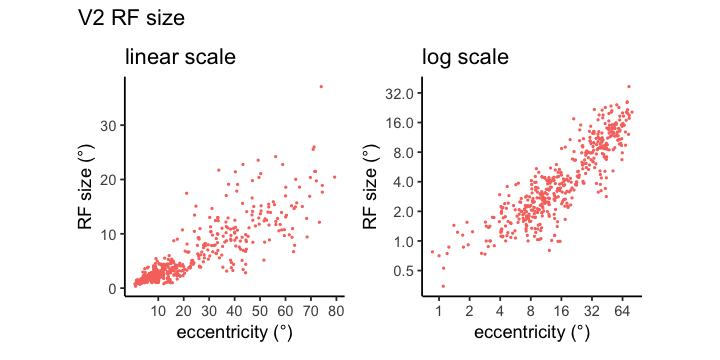

In [12]:
g.V2 <- 
    plot.rf(data, "V2") +
    scale_x_continuous(
        breaks=c(10,20,30,40,50,60,70,80)) +
    scale_y_continuous(
        breaks=c(0,10,20,30,40)) +
    ggtitle("linear scale")

g.V2.log2 <- 
    plot.rf(data, "V2") +
    coord_trans(y='log2', x='log2') +
    scale_x_continuous(
        breaks=c(1,2,4,8,16,32,64)) +
    scale_y_continuous(
        breaks=c(0.5,1,2,4,8,16,32)) +
    ggtitle("log scale")

g.V2 + 
g.V2.log2 +
plot_annotation(
    title = "V2 RF size"
)

The figure above illustrates the RF sizes for area V2.

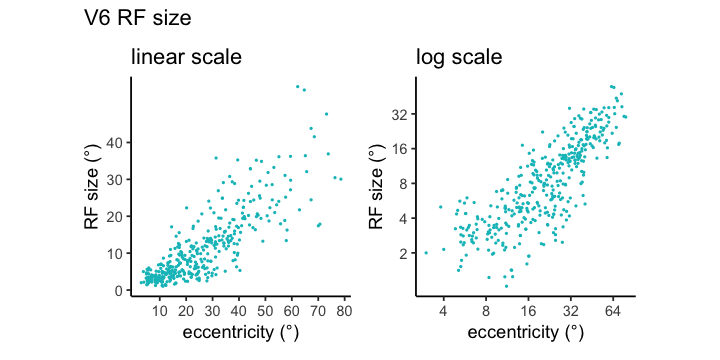

In [13]:
g.V6 <- 
    plot.rf(data,"V6") +
    scale_x_continuous(
        breaks=c(10,20,30,40,50,60,70,80)) +
    scale_y_continuous(
        breaks=c(0,10,20,30,40)) +
    ggtitle("linear scale")

g.V6.log2 <- 
    plot.rf(data,"V6") +
    coord_trans(y='log2', x='log2') +
    scale_x_continuous(
        breaks=c(1,2,4,8,16,32,64)) +
    scale_y_continuous(
        breaks=c(0.5,1,2,4,8,16,32)) +
    ggtitle("log scale")

g.V6 + 
g.V6.log2 +
plot_annotation(
    title = "V6 RF size"
)

The figure above is the distribution of RF for area V6.

### Then, we examine the two areas together

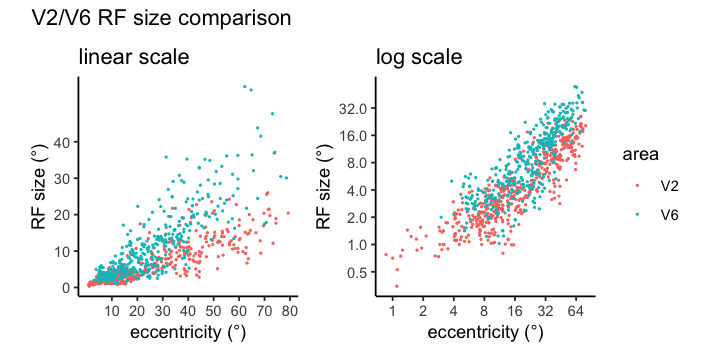

In [14]:
g.V2.V6 <- 
    plot.rf(data, c("V2", "V6")) +
    scale_x_continuous(
        breaks=c(10,20,30,40,50,60,70,80)) +
    scale_y_continuous(
        breaks=c(0,10,20,30,40)) +
    ggtitle("linear scale")

g.V2.V6.log2 <- 
    plot.rf(data, c("V2", "V6"), input.legend.pos="right") +
    coord_trans(y='log2', x='log2') +
    scale_x_continuous(
        breaks=c(1,2,4,8,16,32,64)) +
    scale_y_continuous(
        breaks=c(0.5,1,2,4,8,16,32)) +
    ggtitle("log scale") +
    labs(color="area")

g.V2.V6 + 
g.V2.V6.log2 +
plot_annotation(
    title = "V2/V6 RF size comparison"
)

### Finally, we establish the objectives of the analysis

From the figure above, we observe that V6 neurons tend to have larger RFs than V2 neurons at the same eccentricity. Also, RF sizes appear to grow more rapidly with eccentricity in V6 compared to V2. The rest of this notebook will try to quantify these observations.

## Least-square regression for area V2

The most common way to analyze this data is to use least-sqaure linear regression on the log transformed data. In other words, we assume that RF size grows exponentially with eccentricity. However, more complicated equations have also been used. For example, [Rosa et al. (1997)](https://pubmed.ncbi.nlm.nih.gov/9373013/) used second-order polynomial (ie. quadratic) regression the characterize the size of V2 RFs. The objective of this section is to decide if such complexity is warranted.

Note that since the data is pooled from multiple animals, [mixed models](https://m-clark.github.io/mixed-models-with-R/) are more appropriate. However, because this this dataset does not record the experiments where the individual data points came from, I will leave this issue to a further study.

### First, we build a linear and a quadratic model, and inspect the results

In [15]:
data.V2<-data %>% filter(aggr.area=="V2")

In [16]:
model.V2.linear<-lm(log2.rfsize ~ log2.ecc, data.V2)

Note that polynomial regression in R (`poly(log2.ecc,2)` below) uses orthogonal polynomials to reduce the correlation between `ecc` and `ecc^2`. That is, in general, a better way to do polynomial regression. We don't use it in this particular application, because we want the coefficients to be more interpretable.

In [298]:
#model.V2.poly<-lm(log2.rfsize ~ poly(log2.ecc, 2), data.V2)
model.V2.poly<-lm(log2.rfsize ~ log2.ecc + I(log2.ecc^2), data.V2)

In [299]:
summary(model.V2.linear)


Call:
lm(formula = log2.rfsize ~ log2.ecc, data = data.V2)

Residuals:
     Min       1Q   Median       3Q      Max 
-2.03066 -0.35555  0.02289  0.40167  1.74708 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept) -1.30888    0.08844  -14.80   <2e-16 ***
log2.ecc     0.83754    0.02101   39.86   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.6152 on 467 degrees of freedom
Multiple R-squared:  0.7728,	Adjusted R-squared:  0.7723 
F-statistic:  1589 on 1 and 467 DF,  p-value: < 2.2e-16


In [300]:
summary(model.V2.poly)


Call:
lm(formula = log2.rfsize ~ log2.ecc + I(log2.ecc^2), data = data.V2)

Residuals:
     Min       1Q   Median       3Q      Max 
-1.87367 -0.32244 -0.00245  0.37978  1.86842 

Coefficients:
              Estimate Std. Error t value Pr(>|t|)    
(Intercept)   -0.29493    0.16675  -1.769   0.0776 .  
log2.ecc       0.21034    0.09126   2.305   0.0216 *  
I(log2.ecc^2)  0.08388    0.01191   7.044 6.75e-12 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.5855 on 466 degrees of freedom
Multiple R-squared:  0.7947,	Adjusted R-squared:  0.7938 
F-statistic: 901.8 on 2 and 466 DF,  p-value: < 2.2e-16


Calculate the 95% prediction interval of a given model. At a fixed eccentricity, this interval is the range of RF size that we are 95% confident that the real value falls into:

In [301]:
prediction.df<-function(df, model, interval='prediction') {
    x = seq(
        min(df$log2.ecc),
        max(df$log2.ecc),
        length.out=50
    )
    x.df <- data.frame(log2.ecc=x)
    p <- predict(model, x.df, interval=interval)
    p <- cbind(x.df, p)
    new.df <- data.frame(
        ecc = 2.0^x,
        predicted = 2.0^(p$fit),
        predicted.lwr = 2.0^(p$lwr),
        predicted.upr = 2.0^(p$upr),
        rfsize = 2.0^(p$fit),   # to fool ggplot
        aggr.area = "V2"        # to fool ggplot
    )
    return(new.df)
}

In [302]:
model.V2.linear.pred <- prediction.df(data.V2, model.V2.linear)
model.V2.poly.pred <- prediction.df(data.V2, model.V2.poly)

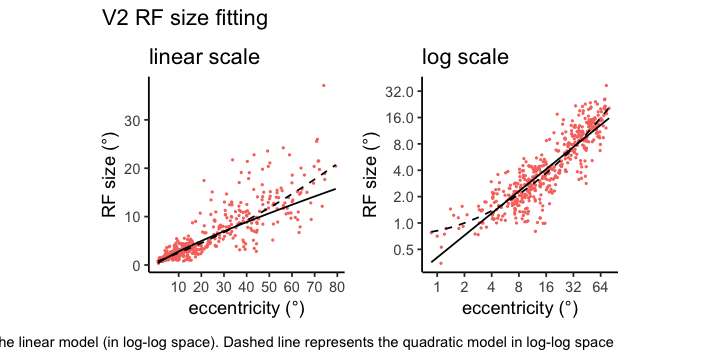

In [303]:
g.pred <- 
    g.V2 +
    geom_line(
        data=model.V2.linear.pred,
        aes(x=ecc, y=predicted),
        color='black') +
    geom_line(
        data=model.V2.poly.pred,
        aes(x=ecc, y=predicted),
        color='black',
        linetype='dashed')

g.pred.log2 <- 
    g.V2.log2 +
    geom_line(
        data=model.V2.linear.pred,
        aes(x=ecc, y=predicted),
        color='black') +
    geom_line(
        data=model.V2.poly.pred,
        aes(x=ecc, y=predicted),
        color='black',
        linetype='dashed')

g.pred + 
g.pred.log2 + 
plot_annotation(
    title = "V2 RF size fitting",
    caption = "Solid lines represents the linear model (in log-log space). Dashed line represents the quadratic model in log-log space "
)

The figure above shows that the linear model has a tendency to underestimate RF size at the very low end and the very high end of eccentricity. As pointed out previously by [Rosa et al. (1997)](https://pubmed.ncbi.nlm.nih.gov/9373013/), the quadratic model appears to capture the two ends more accurately. However, it is not clear at this point if the quadratic model is worthy of the trouble. The R^2 was only slightly improved, and there are good reasons to believe that deviations from the linear model are due to experimental errors. Measuring very small and very large RFs is technically difficult. They are easy to overestimate.

Before we answer this question, let's examine the models a little further. Let's check the  95% prediction intervals:

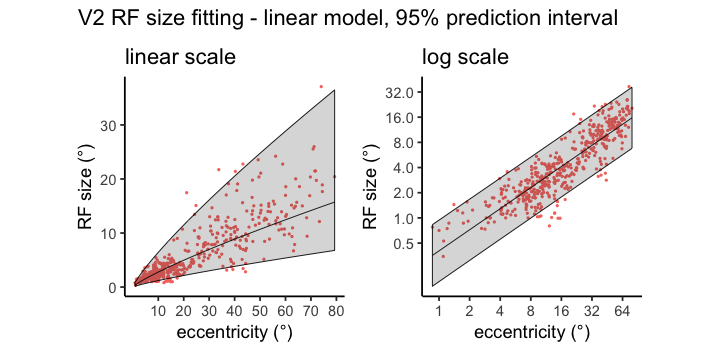

In [23]:
g.pred <-
    g.V2 +
    geom_line(
        data=model.V2.linear.pred,
        aes(x=ecc, y=predicted),
        size=0.25,
        color='black') +
    geom_ribbon(
        data=model.V2.linear.pred,
        aes(ymin=predicted.lwr, ymax=predicted.upr),
        color='black',
        size=0.25,
        alpha=0.2)

g.pred.log2 <-
    g.V2.log2 +
    geom_line(
        data=model.V2.linear.pred,
        aes(x=ecc, y=predicted),
        size=0.25,
        color='black') +
    geom_ribbon(
        data=model.V2.linear.pred,
        aes(ymin=predicted.lwr, ymax=predicted.upr),
        color='black',
        size=0.25,
        alpha=0.2)

g.pred + 
g.pred.log2 + 
plot_annotation(
    title = "V2 RF size fitting - linear model, 95% prediction interval",
)

The figure above shows that the majority of the data points fall into the 95% confident range of the predicted values. There were only small number of outliers. 

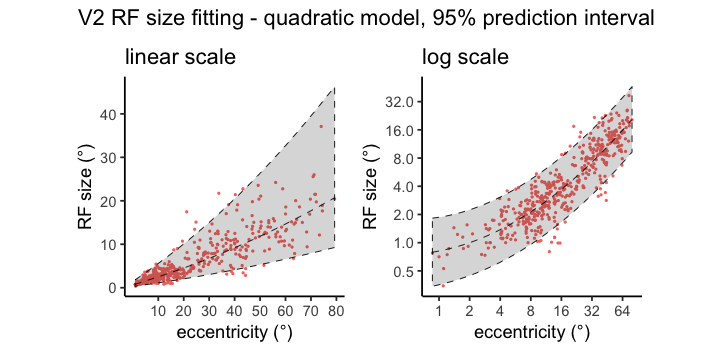

In [24]:
g.pred <-
    g.V2 +
    geom_line(
        data=model.V2.poly.pred,
        aes(x=ecc, y=predicted),
        size=0.25,
        color='black',
        linetype='dashed') +
    geom_ribbon(
        data=model.V2.poly.pred,
        aes(ymin=predicted.lwr, ymax=predicted.upr),
        color='black',
        size=0.25,
        alpha=0.2,
        linetype='dashed')

g.pred.log2 <-
    g.V2.log2 +
    geom_line(
        data=model.V2.poly.pred,
        aes(x=ecc, y=predicted),
        size=0.25,
        color='black',
        linetype='dashed') +
    geom_ribbon(
        data=model.V2.poly.pred,
        aes(ymin=predicted.lwr, ymax=predicted.upr),
        color='black',
        size=0.25,
        alpha=0.2,
        linetype='dashed')

g.pred + 
g.pred.log2 + 
plot_annotation(
    title = "V2 RF size fitting - quadratic model, 95% prediction interval",
)

The figure above shows that the prediction interval of the quadratic model has a different shape, but it is not obviously better.

### Is the more complicated model justified?

Calculates the absolute errors of the model predictions, and translate back to the physical unit of degree:

In [25]:
abs.errs <- function(df, model) {
    tmp <- cbind(df, fitted(model))
    n <- length(names(tmp))
    names(tmp)[n] <- "fitted" # rename the last column to make it easier to refer to
    errs <- abs(2.0^tmp$fitted - tmp$rfsize)
    return (errs)
}

The structure of this data frame is intended to be used for ggplot's boxplot, but I have omitted this plot:

In [26]:
errs.df <- rbind(
    data.frame(
        model = rep('linear', nrow(data.V2)),
        err = abs.errs(data.V2, model.V2.linear)),
    data.frame(
        model = rep('poly', nrow(data.V2)),
        err = abs.errs(data.V2, model.V2.poly)))

In [27]:
tmp <- summary(
    cbind(
        errs.df %>% filter(model=="linear") %>% select(err),
        errs.df %>% filter(model=="poly") %>% select(err)))

attr(tmp, "dimnames")[2] <- list(c("  err (linear)", "  err (quadratic)"))
tmp

   err (linear)        err (quadratic) 
 Min.   : 0.002452   Min.   : 0.00301  
 1st Qu.: 0.434112   1st Qu.: 0.33708  
 Median : 0.983026   Median : 0.91760  
 Mean   : 1.877943   Mean   : 1.76186  
 3rd Qu.: 2.270184   3rd Qu.: 2.05348  
 Max.   :22.249964   Max.   :18.12214  

The table above summarizes the absolute errors of the linear model (left) and the quadratic model (right), in the physical unit of RF size (°). The errors of the second model are smaller, but the differences are small (less than 1°). 

More complex models have higher degrees of freedom, so it's not surprising that their predictions are more accurate. They are not necessarily better models. The crucial question is if the performance gained is justified by the higher number of parameters. A Bayesian approach for selecting the better model begins with the calculation of the Bayesian Information Criterion (BIC): 

In [28]:
bic0 <- BIC(model.V2.linear)
bic1 <- BIC(model.V2.poly)

Assuming that the linear and the quadratic model have the same prior probability, the model with the smaller BIC is the better model. We can conclude that the quadratic model is indeed better.

In [29]:
data.frame(model = c('linear','quadratic'), BIC=c(bic0, bic1))

model,BIC
linear,891.7469
quadratic,850.4456


The following is the posterior probability that the quadratic model is the better model of the two. Based on this probability, we conclude that the use of second-order polynomials is justified.

In [30]:
exp(-0.5*bic1)/(exp(-0.5*bic0) + exp(-0.5*bic1))

[1] 1

## Use Model II regression to account for the errors of eccentricity measures
In least-square regression, the covariate is not a random variable. It is typically a factor that is manipulated in experiments so it is not subject to measurement error. However, in our problem, eccentricity is a measured quantity. The uncertainty associated with it is not accounted for in the least-square model. 

Model II regression can be used to address this issue. In R, we can use the [lmodel2](https://cran.r-project.org/web/packages/lmodel2/lmodel2.pdf) package. The package implements several estimation methods. Since the magnitude of error of eccentricity should be similar to that of RF size, we will use major-axis regression.

In [31]:
model.V2.linear2 <- lmodel2(log2.rfsize ~ log2.ecc, data = data.V2)

RMA was not requested: it will not be computed.

No permutation test will be performed


In [32]:
model.V2.linear2


Model II regression

Call: lmodel2(formula = log2.rfsize ~ log2.ecc, data = data.V2)

n = 469   r = 0.8790969   r-square = 0.7728114 
Parametric P-values:   2-tailed = 2.182807e-152    1-tailed = 1.091403e-152 
Angle between the two OLS regression lines = 7.354264 degrees

Regression results
  Method Intercept     Slope Angle (degrees) P-perm (1-tailed)
1    OLS -1.308883 0.8375393        39.94750                NA
2     MA -1.742810 0.9464087        43.42285                NA
3    SMA -1.767994 0.9527270        43.61321                NA

Confidence intervals
  Method 2.5%-Intercept 97.5%-Intercept 2.5%-Slope 97.5%-Slope
1    OLS      -1.482677       -1.135089  0.7962461   0.8788325
2     MA      -1.933284       -1.561012  0.9007966   0.9941972
3    SMA      -1.936143       -1.606974  0.9123282   0.9949146

Eigenvalues: 3.283204 0.2106824 

H statistic used for computing C.I. of MA: 0.0006058561 


This function extracts the major axis model from the model II regression:

In [33]:
get.MA.func <- function(model) {
    params <- model$regression.results %>% filter(Method=="MA")
    intercept <- params$Intercept
    slope <- params$Slope
    f <- function(log2.ecc) {
        return (intercept + slope*log2.ecc)
    }
}

In [34]:
prediction2.df<-function(df, f) {
    x = seq(
        min(df$log2.ecc),
        max(df$log2.ecc),
        length.out=50
    )
    new.df <- data.frame(
        log2.ecc = x,
        ecc = 2.0^x,
        aggr.area = "V2"
    )
    new.df <- new.df %>% mutate(
        predicted=2.0^f(log2.ecc),
        rfsize=2.0^f(log2.ecc)
    )
    return(new.df)
}

In [35]:
model.V2.linear2.pred <- prediction2.df(data.V2, get.MA.func(model.V2.linear2))

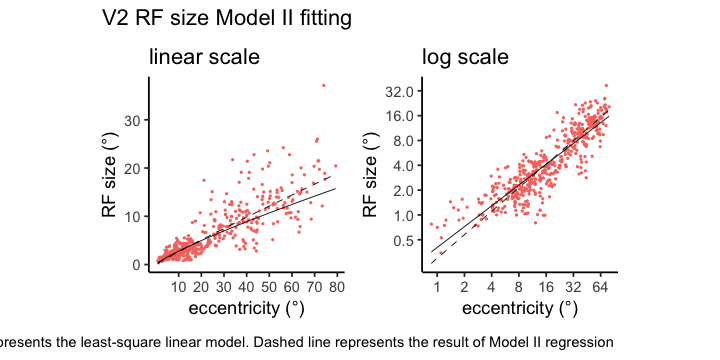

In [36]:
g.pred <-
    g.V2 +
    geom_line(
        data=model.V2.linear.pred,
        aes(x=ecc, y=predicted),
        size=0.25,
        color='black') +
    geom_line(
        data=model.V2.linear2.pred,
        aes(x=ecc, y=predicted),
        size=0.25,
        color='black',
        linetype='dashed')

g.pred.log2 <-
    g.V2.log2 +
    geom_line(
        data=model.V2.linear.pred,
        aes(x=ecc, y=predicted),
        size=0.25,
        color='black') +
    geom_line(
        data=model.V2.linear2.pred,
        aes(x=ecc, y=predicted),
        size=0.25,
        color='black',
        linetype='dashed')

g.pred + 
g.pred.log2 +
plot_annotation(
    title = "V2 RF size Model II fitting",
    caption = "Solid lines represents the least-square linear model. Dashed line represents the result of Model II regression "
)

Recall that at very large eccentricity, least-square regression (solid lines in the figure above) tends to underestimate the RF size, but this error can be reduced by the quadratic model. The figure above suggests that this underestimation might be due to the uncertainty of eccentricity. 

Interestingly, Model II regression estimated even smaller RFs at the lowest range of eccentricity than the least-square estimates. This result is consistent with the common finding that least-square regression tends to underestimate the slopes of measured covariates.

## The analysis of V6 RFs

Now, we perform the same analysis for area V6.

In [37]:
data.V6<-data %>% filter(aggr.area=="V6")
model.V6.linear<-lm(log2.rfsize ~ log2.ecc, data.V6)
model.V6.poly<-lm(log2.rfsize ~ poly(log2.ecc, 2), data.V6)

In [38]:
bic0 <- BIC(model.V6.linear)
bic1 <- BIC(model.V6.poly)

In [39]:
exp(-0.5*bic1)/(exp(-0.5*bic0) + exp(-0.5*bic1))

[1] 0.9999999

In [40]:
model.V6.linear2 <- lmodel2(log2.rfsize~log2.ecc, data.V6)

RMA was not requested: it will not be computed.

No permutation test will be performed


In [41]:
model.V6.poly.pred <- prediction.df(data.V6, model.V6.poly)

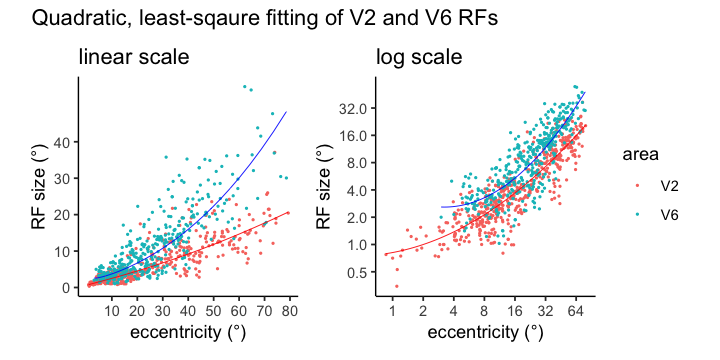

In [42]:
g.pred <-
    g.V2.V6 +
    geom_line(
        data=model.V2.poly.pred,
        aes(x=ecc, y=predicted),
        size=0.25,
        color='red') +
    geom_line(
        data=model.V6.poly.pred,
        aes(x=ecc, y=predicted),
        size=0.25,
        color='blue') +
    theme(
        aspect.ratio=1,
        panel.grid.major = element_blank(),
        panel.grid.minor = element_blank(),
        axis.line = element_line(
            size = 0.4, 
            linetype = "solid",
            colour = "black")
    )

g.pred.log2 <-
    g.V2.V6.log2 +
    geom_line(
        data=model.V2.poly.pred,
        aes(x=ecc, y=predicted),
        size=0.25,
        color='red') +
    geom_line(
        data=model.V6.poly.pred,
        aes(x=ecc, y=predicted),
        size=0.25,
        color='blue') +
    theme(
        aspect.ratio=1,
        panel.grid.major = element_blank(),
        panel.grid.minor = element_blank(),
        axis.line = element_line(
            size = 0.4, 
            linetype = "solid",
            colour = "black")
    )

g.pred + 
g.pred.log2 +
plot_annotation(
    title = "Quadratic, least-sqaure fitting of V2 and V6 RFs",
)

In [43]:
model.V6.linear2 <- lmodel2(log2.rfsize~log2.ecc, data.V6)
model.V6.linear2.pred <- prediction2.df(data.V6, get.MA.func(model.V6.linear2))

RMA was not requested: it will not be computed.

No permutation test will be performed


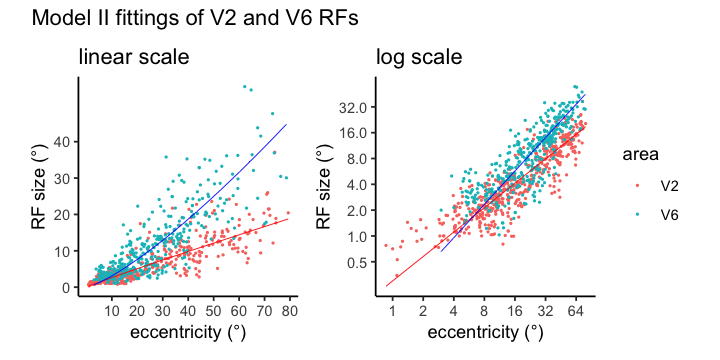

In [44]:
g.pred <-
    g.V2.V6 +
    geom_line(
        data=model.V2.linear2.pred,
        aes(x=ecc, y=predicted),
        size=0.25,
        color='red') +
    geom_line(
        data=model.V6.linear2.pred,
        aes(x=ecc, y=predicted),
        size=0.25,
        color='blue')

g.pred.log2 <-
    g.V2.V6.log2 +
    geom_line(
        data=model.V2.linear2.pred,
        aes(x=ecc, y=predicted),
        size=0.25,
        color='red') +
    geom_line(
        data=model.V6.linear2.pred,
        aes(x=ecc, y=predicted),
        size=0.25,
        color='blue')

g.pred + 
g.pred.log2 +
plot_annotation(
    title = "Model II fittings of V2 and V6 RFs",
)

## Use ANCOVA and permutation tests to decide if V2 and V6 are different 

The previous section strongly suggests that RFs are larger in V6 than in V2, but we have not established this observation statistically.

This question can be formulated as a ANCOVA (Analysis of Covariance) problem:

In [45]:
data$aggr.area <- as.factor(data$aggr.area)

In [46]:
summary(lm(log2.rfsize ~ log2.ecc * aggr.area, data))


Call:
lm(formula = log2.rfsize ~ log2.ecc * aggr.area, data = data)

Residuals:
     Min       1Q   Median       3Q      Max 
-2.12063 -0.37155  0.05197  0.42354  1.75652 

Coefficients:
                     Estimate Std. Error t value Pr(>|t|)    
(Intercept)          -1.30888    0.09553 -13.701  < 2e-16 ***
log2.ecc              0.83754    0.02270  36.899  < 2e-16 ***
aggr.areaV6          -0.04932    0.18032  -0.274 0.784504    
log2.ecc:aggr.areaV6  0.15916    0.04093   3.889 0.000109 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.6645 on 852 degrees of freedom
Multiple R-squared:  0.7585,	Adjusted R-squared:  0.7577 
F-statistic: 892.1 on 3 and 852 DF,  p-value: < 2.2e-16


The above indicates that the regression line is significantly dependent on the area (see the 4th row of `Coefficients`). We can also perform the same test for a quadratic model:

In [47]:
summary(lm(log2.rfsize ~ poly(log2.ecc, 2) * aggr.area, data))


Call:
lm(formula = log2.rfsize ~ poly(log2.ecc, 2) * aggr.area, data = data)

Residuals:
     Min       1Q   Median       3Q      Max 
-1.99107 -0.33675  0.02634  0.40173  1.86842 

Coefficients:
                               Estimate Std. Error t value Pr(>|t|)    
(Intercept)                     2.15959    0.02961  72.929  < 2e-16 ***
poly(log2.ecc, 2)1             30.57380    0.77833  39.281  < 2e-16 ***
poly(log2.ecc, 2)2              4.73615    0.72672   6.517 1.23e-10 ***
aggr.areaV6                     0.72510    0.04630  15.660  < 2e-16 ***
poly(log2.ecc, 2)1:aggr.areaV6  0.20110    1.55633   0.129 0.897217    
poly(log2.ecc, 2)2:aggr.areaV6  6.49738    1.79083   3.628 0.000303 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.6328 on 850 degrees of freedom
Multiple R-squared:  0.7816,	Adjusted R-squared:  0.7803 
F-statistic: 608.2 on 5 and 850 DF,  p-value: < 2.2e-16


Again, the best-fit model is significantly dependent on the area. 

We have reached a statistical conclusion about RFs in V2 and V6. However, there are two problems:

1. In ANCOVA, the slope in the linear model is assumed to be the same for the two areas. This assumption is  unlikely to be true, based on our knowledge about visual areas. The quadratic model also has the same problem.
2. Since ANCOVA is a least-square method, it does not account for the uncertainty in eccentricity measurements.

To address these two issues, I implemented a permutation test in Hadjidimitrakis et al. (2019). I will not repeat it here, but in short:
1. Under the null hypothesis that the RF size vs. eccentricity relationship is the same for V2 and V6, I took random samples from the pooled dataset, and used Model II regression to extract two model parameters (intercept and slope).
2. I repeated this process many times, to build a joint distribution of the two parameters. 
3. I approximated the distribution with a bivariate Gaussian distribution, and used it to estimate the probability that the RF sizes in the two areas were indistinguishable, given the data.
4. I concluded that the null hypothesis was unlikely (p<0.001).

This strategy did manage to establish a p-value for comparing two Model II regression results, but it was still unsatisfying for two reasons:
1. The permutation test doesn't give the best estimate of the relationship, and
2. It doesn't easily extend to polynomial models. Estimating the joint probability of the parameters would be difficult.

In the rest of this notebook, we'll see if we can do better with Bayesian methods.

## Simple Bayesian regression for area V2

We start with the simplest Bayesian model. The log transformed RF size $y$ is related to the log transformed eccentricity $x$ as:

$ 
\begin{align}
y \sim N(\mu_x, \sigma^2) 
\end{align}
$

$ 
\begin{align}
\mu_x = \beta_0  + \beta_1 x 
\end{align}
$

$\beta_0$, $\beta_1$ and $\sigma$ are random variable with broadly distributed priors. Note that in this formulation, $y$ is a Gaussian random variable, but $x$ is not. This model is similar to the least-square model in that both do not take the uncertainty of eccentricity into account.

This is how we implement it in JAGS:

In [203]:
# bundle data for JAGS
jags.Data.Desc <- list(
    x = data.V2$log2.ecc,
    y = data.V2$log2.rfsize
)

# define the Bayesian model
jags.Model.String <- "
# standardize x and y into zx and zy
data {
    N <- length(y)
    mx <- mean(x)
    my <- mean(y)
    sdx <- sd(x)
    sdy <- sd(y)
    for (i in 1:length(y)) {
        zx[i] <- (x[i] - mx) / sdx
        zy[i] <- (y[i] - my) / sdy
    }
}

model {
    # likelihood
    for (i in 1:N) {
        zy[i] ~ dnorm(mu[i], 1/zsigma^2)
        mu[i] <- zbeta0 + zbeta1 * zx[i]
    }
    
    # priors - these are all vague prior on standardized scale
    zbeta0 ~ dnorm( 0, 1/(10)^2 )
    zbeta1 ~ dnorm( 0, 1/(10)^2 )
    zsigma ~ dunif( 1.0E-3, 1.0E+3)

    # transform to original scale
    beta1 <- zbeta1 * sdy / sdx
    beta0 <- zbeta0 * sdy + my - zbeta1 * mx * sdy / sdx
    sigma <- zsigma * sdy
}
"
writeLines(jags.Model.String, con="tmp-jags-model.txt")

Now use JAGS to run the MCMC simulation:

In [204]:
jags.V2.linear = jags(
    data     = jags.Data.Desc,
    inits    = NULL,
    parameters.to.save = c('beta0', 'beta1','sigma'),
    model.file = "tmp-jags-model.txt",
    n.chains = 3,
    n.iter   = 1000,
    n.burnin = 300
)

Compiling data graph
   Resolving undeclared variables
   Allocating nodes
   Initializing
   Reading data back into data table
Compiling model graph
   Resolving undeclared variables
   Allocating nodes
Graph information:
   Observed stochastic nodes: 469
   Unobserved stochastic nodes: 3
   Total graph size: 2812

Initializing model



Check the result:

In [50]:
tidyMCMC(as.mcmc(jags.V2.linear), conf.int = TRUE, conf.method = "HPDinterval")

term,estimate,std.error,conf.low,conf.high
beta0,-1.3061339,0.08874444,-1.4863436,-1.1374379
beta1,0.8372653,0.02101126,0.7993928,0.8805570
sigma,0.6165678,0.02025721,0.5758849,0.6548733


The estimates are (unsurprisingly) very close to the estimates produced by least-square regression. While this table doesn't look too different from the least-square result, the meaning is very different. In the Bayesian model, the full posterior distributions of $\beta_0$, $\beta_1$ and $\sigma$ have been estimated by Monte Carlo sampling:

Warning message:
“Removed 1 rows containing non-finite values (stat_bin).”Warning message:
“Removed 2 rows containing missing values (geom_bar).”Warning message:
“Removed 2 rows containing missing values (geom_bar).”Warning message:
“Removed 2 rows containing missing values (geom_bar).”

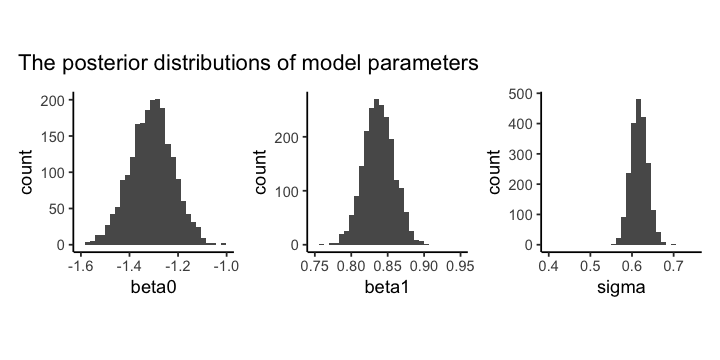

In [51]:
tmp <- as.matrix(as.mcmc(jags.V2.linear))

g.tmp1a <- ggplot(
    data.frame(tmp),
    aes(x=beta0)) +
geom_histogram(bins=30) + 
scale_x_continuous(
    limits = c(-1.6,-1.0)
) +
theme_classic() +
theme(
    aspect.ratio=1)

g.tmp2b <- ggplot(
    data.frame(tmp),
    aes(x=beta1)) +
geom_histogram(bins=30) + 
scale_x_continuous(
    limits = c(0.75, 0.95)
) +
theme_classic() +
theme(
    aspect.ratio=1)

g.tmp3c <- ggplot(
    data.frame(tmp),
    aes(x=sigma)) +
geom_histogram(bins=30) + 
scale_x_continuous(
    limits = c(0.4, 0.75)
) +
theme_classic() +
theme(
    aspect.ratio=1)

gg1 <-
g.tmp1a + 
g.tmp2b + 
g.tmp3c 

gg1 +
plot_annotation(
    title = "The posterior distributions of model parameters",
)


In the figure above, the posterior distribution of $\beta_1$ is of particular interest because it is the slope of the regression line. We can see that the estimated distribution is narrow. The 95% HPD (high posterior density) interval is (0.79, 0.88).

Let's compare the Bayesian model to the least-square model. For this comparison, I'll only plot the uncertainty about $\mu_x$ rather than $y$. Previously, we plotted the prediction intervals of the least-square model. Here, we'll plot the confidence intervals, and then compare them to that of the Bayesian model. It's harder to work with the Bayesian model, because $\beta_0$ and $\beta_1$ are not just two numbers. Rather, they are sampled thousands of times by MCMC. We therefore have to calculate $\mu_x$ thousands of times, and the calculate the HPD intervals:

In [52]:
tmp.newdf <- data.frame(
    log2x = seq(
        min(data.V2$log2.ecc), 
        max(data.V2$log2.ecc), 
        len = 200)
)

tmp.mcmc <- jags.V2.linear$BUGSoutput$sims.matrix
tmp.X <- model.matrix(~log2x, tmp.newdf)
tmp.coefs <- tmp.mcmc[, c("beta0", "beta1")]
tmp.fit <- tmp.coefs %*% t(tmp.X)
tmp.newdf <- tmp.newdf %>% cbind(tidyMCMC(tmp.fit, conf.int = TRUE, conf.method = "HPDinterval"))
tmp.newdf <- tmp.newdf %>% mutate(x=2^log2x, y=2^estimate, y.low=2^conf.low, y.high=2^conf.high)

tmp.g.bayes <- 
    ggplot(tmp.newdf, 
           aes(x = x, y = y)) + 
    geom_line(size=0.25) + 
    geom_ribbon(
        aes(
        ymin = y.low,
        ymax = y.high), 
    fill = "red", alpha = 0.3) + 
    labs(
        x="eccentricity (°)",
        y="RF size (°)") + 
    theme_classic() +
    theme(
        aspect.ratio=1
    ) +
    ggtitle("bayesian")

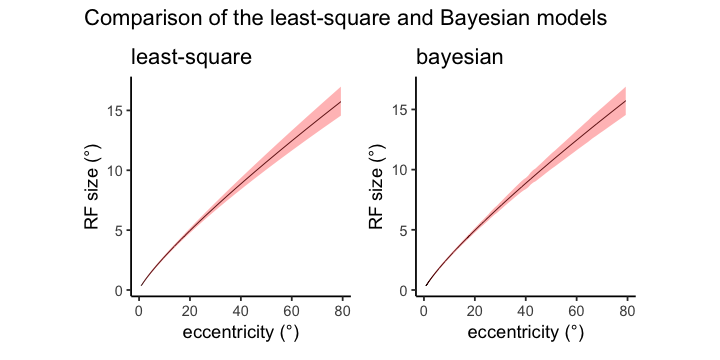

In [53]:
model.V2.linear.pred <- prediction.df(data.V2, model.V2.linear, interval = "confidence")
tmp.g.leastsq <-
    ggplot(model.V2.linear.pred, aes(x=ecc)) +
    geom_line(
        data=model.V2.linear.pred,
        aes(x=ecc, y=predicted),
        size=0.25,
        color='black') +
    geom_ribbon(
        data=model.V2.linear.pred,
        aes(ymin=predicted.lwr, ymax=predicted.upr),
        fill='red',
        alpha=0.3) +
    labs(
        x="eccentricity (°)",
        y="RF size (°)") + 
    theme_classic() + 
    theme(
        aspect.ratio=1
    ) + 
    ggtitle("least-square")

tmp.g.leastsq +
tmp.g.bayes + 
plot_annotation(
    title = "Comparison of the least-square and Bayesian models",
)

The figure above shows that both models estimated similar levels of uncertainty for the mean RF size.

## Incorporating uncertainty about the covariate into the Bayesian model

Previously, we used Model II regression to account for the uncertainty about the measured eccentricity. A problem is that because Model II regression is not a least-square method, it doesn't integrate well into the generalized linear model framework. Under the Bayesian framework, however, it is very natural to make $x$ a random variable. 

Note that in the implementation below, I gave RF size and eccentricity independent noises of the same magnitude. This reflects the fact that both measures were derived from the same RF outlines that were recorded in the experiment. Uncertainty about the two are expected to be similar. If the uncertainty of the two measures were allowed to have different magnitude in the model, MCMC produced bi-stable estimates that are unrealistic in the context of this experiment.

In [207]:
# bundle data for JAGS
jags.Data.Desc <- list(
    x = data.V2$log2.ecc,
    y = data.V2$log2.rfsize
)

# define the Bayesian model
jags.Model.String <- "
# standardize x and y into zx and zy
data {
    N <- length(y)
    mx <- mean(x)
    my <- mean(y)
    sdx <- sd(x)
    sdy <- sd(y)
    for (i in 1:length(y)) {
        zx[i] <- (x[i] - mx) / sdx
        zy[i] <- (y[i] - my) / sdy
    }
}

model {
    # likelihood
    for (i in 1:N) {
        zy[i]  ~ dnorm(mu[i], 1/zsigma^2)
        zxn[i] ~ dnorm(zx[i], 1/zsigma^2)
        mu[i] <- zbeta0 + zbeta1 * zxn[i]
    }
    
    # priors - these are all vague prior on standardized scale
    zbeta0 ~ dnorm( 0, 1/(10)^2 )
    zbeta1 ~ dnorm( 0, 1/(10)^2 )
    zsigma ~ dunif( 1.0E-3, 1.0E+3)

    # transform to original scale. Algebra solved by Mathematica
    beta1 <- zbeta1 * sdy / sdx
    beta0 <- zbeta0 * sdy + my - zbeta1 * mx * sdy / sdx
    sigma <- zsigma * sdy
}
"
writeLines(jags.Model.String, con="tmp-jags-model2.txt")

In [208]:
jags.V2.linear2 = jags(
    data     = jags.Data.Desc,
    inits    = NULL,
    parameters.to.save = c('beta0', 'beta1', 'sigma', 'zbeta0', 'zbeta1', 'zsigma'),
    model.file = "tmp-jags-model2.txt",
    n.chains = 3,
    n.iter   = 1000,
    n.burnin = 300
)

Compiling data graph
   Resolving undeclared variables
   Allocating nodes
   Initializing
   Reading data back into data table
Compiling model graph
   Resolving undeclared variables
   Allocating nodes
Graph information:
   Observed stochastic nodes: 469
   Unobserved stochastic nodes: 472
   Total graph size: 3309

Initializing model



In [67]:
tidyMCMC(as.mcmc(jags.V2.linear2), conf.int = TRUE, conf.method = "HPDinterval")

term,estimate,std.error,conf.low,conf.high
beta0,-1.315001442,0.08906932,-1.48366392,-1.14377008
beta1,0.839060652,0.02099759,0.79851520,0.87910198
sigma,0.463197598,0.01614207,0.43057584,0.49319731
zbeta0,-0.000989798,0.02167451,-0.04381365,0.04221851
zbeta1,0.880693702,0.02203946,0.83813644,0.92272183
zsigma,0.359250349,0.01251959,0.33394931,0.38251775


Warning message:
“Removed 1 rows containing non-finite values (stat_bin).”Warning message:
“Removed 2 rows containing missing values (geom_bar).”Warning message:
“Removed 2 rows containing missing values (geom_bar).”Warning message:
“Removed 2 rows containing missing values (geom_bar).”Warning message:
“Removed 3 rows containing non-finite values (stat_bin).”Warning message:
“Removed 2 rows containing missing values (geom_bar).”Warning message:
“Removed 2 rows containing missing values (geom_bar).”Warning message:
“Removed 2 rows containing missing values (geom_bar).”

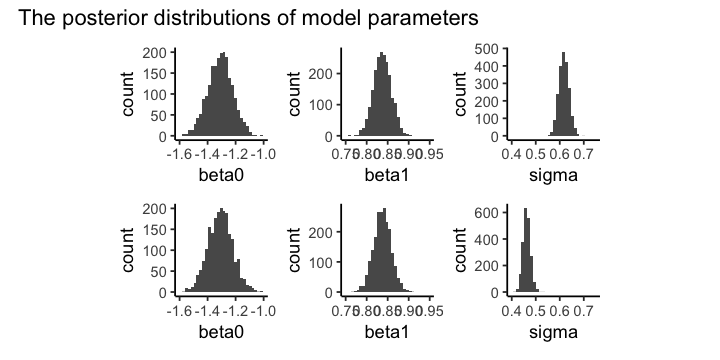

In [57]:
tmp <- as.matrix(as.mcmc(jags.V2.linear2))

g.tmp1a <- ggplot(
    data.frame(tmp),
    aes(x=beta0)) +
geom_histogram(bins=30) + 
scale_x_continuous(
    limits = c(-1.6,-1.0)
) +
theme_classic() +
theme(
    aspect.ratio=1)

g.tmp2b <- ggplot(
    data.frame(tmp),
    aes(x=beta1)) +
geom_histogram(bins=30) + 
scale_x_continuous(
    limits = c(0.75, 0.95)
) +
theme_classic() +
theme(
    aspect.ratio=1)

g.tmp3c <- ggplot(
    data.frame(tmp),
    aes(x=sigma)) +
geom_histogram(bins=30) + 
scale_x_continuous(
    limits = c(0.4, 0.75)
) +
theme_classic() +
theme(
    aspect.ratio=1)

gg2 <- 
g.tmp1a + 
g.tmp2b + 
g.tmp3c 


gg1 /
gg2 + 
plot_annotation(
    title = "The posterior distributions of model parameters",
)


The figure above compares the posterior distributions of the parameters estimated for the simple Bayesian regression model that we have already seen in the previous section (top row), and those for the Bayesian model discussed in this section (bottom row). The regression lines (i.e., $\beta_0$ and $\beta_1$) are remarkably similar. The most significant difference is that by allowing errors in the covariate, we were able to derive a tighter relationship (i.e., $\sigma$ is smaller).

Recall that earlier in this notebook, we observed that frequentist Model II regression suggested that the slope of the regression line was underestimated by linear regression. The Bayesian model, however, does not agree with this conclusion. This is most likely because the noise structure of major-axis Model II regression is too flexible. It's an issue that requires further investigation.

## Use Bayesian model section to evaluate the quadratic model

As we have done previously, we want to know if RF size is better modeled as a quadratic function. Again we give both RF size and eccentricity some degree of uncertainty. This is a model that we couldn't do with `lmodel2`:

In [210]:
# bundle data for JAGS
jags.Data.Desc <- list(
    x = data.V2$log2.ecc,
    y = data.V2$log2.rfsize
)

# define the Bayesian model
jags.Model.String <- "
# standardize x and y into zx and zy
data {
    N <- length(y)
    mx <- mean(x)
    my <- mean(y)
    sdx <- sd(x)
    sdy <- sd(y)
    for (i in 1:length(y)) {
        zx[i] <- (x[i] - mx) / sdx
        zy[i] <- (y[i] - my) / sdy
    }
}

model {
    # likelihood
    for (i in 1:N) {
        zy[i]  ~ dnorm(mu[i], 1/zsigma^2)
        zxn[i] ~ dnorm(zx[i], 1/zsigma^2)
        mu[i] <- zbeta0 + zbeta1 * zxn[i] + zbeta2 * pow(zxn[i], 2)
    }
    
    # priors - these are all vague prior on standardized scale
    zbeta0 ~ dnorm( 0, 1/(10)^2 )
    zbeta1 ~ dnorm( 0, 1/(10)^2 )
    zbeta2 ~ dnorm( 0, 1/(10)^2 )
    zsigma ~ dunif( 1.0E-3, 1.0E+3)

    # transform to original scale. Algebra solved by Mathematica
    beta2 <- sdy * zbeta2 / pow(sdx, 2)
    beta1 <- sdy * (sdx * zbeta1 - 2 * mx * zbeta2) / pow(sdx, 2)
    beta0 <- my + sdy * (pow(sdx, 2) * zbeta0 - mx * sdx * zbeta1 + pow(mx, 2) * zbeta2)/pow(sdx, 2)
    sigma <- zsigma * sdy
}
"
writeLines(jags.Model.String, con="tmp-jags-model3.txt")

In [211]:
jags.V2.poly = jags(
    data     = jags.Data.Desc,
    inits    = NULL,
    parameters.to.save = c('beta0', 'beta1', 'beta2', 'sigma', 'zbeta0', 'zbeta1', 'zbeta2', 'zsigma'),
    model.file = "tmp-jags-model3.txt",
    n.chains = 3,
    n.iter   = 1000,
    n.burnin = 300
)

Compiling data graph
   Resolving undeclared variables
   Allocating nodes
   Initializing
   Reading data back into data table
Compiling model graph
   Resolving undeclared variables
   Allocating nodes
Graph information:
   Observed stochastic nodes: 469
   Unobserved stochastic nodes: 473
   Total graph size: 4258

Initializing model



In [71]:
tidyMCMC(as.mcmc(jags.V2.poly), conf.int = TRUE, conf.method = "HPDinterval")

term,estimate,std.error,conf.low,conf.high
beta0,-0.41529850,0.13579676,-0.67389806,-0.15288880
beta1,0.28112617,0.07825491,0.13672563,0.44168014
beta2,0.07411804,0.01073273,0.05295820,0.09501937
sigma,0.43384715,0.01505462,0.40435671,0.46405878
zbeta0,-0.11724407,0.02714383,-0.16608865,-0.06131002
zbeta1,0.91378300,0.02362270,0.86845864,0.95980999
zbeta2,0.10528248,0.01524552,0.07522555,0.13497220
zsigma,0.33648650,0.01167618,0.31361408,0.35991827


In [212]:
jags.V2.poly

Inference for Bugs model at "tmp-jags-model3.txt", fit using jags,
 3 chains, each with 1000 iterations (first 300 discarded)
 n.sims = 2100 iterations saved
         mu.vect sd.vect    2.5%     25%     50%     75%   97.5%  Rhat n.eff
beta0     -0.416   0.133  -0.686  -0.505  -0.414  -0.326  -0.166 1.002  1100
beta1      0.280   0.076   0.138   0.229   0.279   0.330   0.434 1.007   800
beta2      0.074   0.010   0.054   0.067   0.074   0.081   0.093 1.002   990
sigma      0.434   0.016   0.405   0.423   0.434   0.443   0.467 1.000  2100
zbeta0    -0.117   0.027  -0.167  -0.136  -0.118  -0.099  -0.063 1.001  1700
zbeta1     0.914   0.022   0.872   0.900   0.913   0.929   0.958 1.002  1100
zbeta2     0.105   0.014   0.076   0.096   0.106   0.115   0.132 1.002   990
zsigma     0.337   0.012   0.314   0.328   0.336   0.344   0.362 1.000  2100
deviance 316.259  30.039 258.064 296.805 315.685 335.769 374.120 1.000  2100

For each parameter, n.eff is a crude measure of effective sample size,


Note that the HPD interval of $\beta_2$ excludes 0, so we have some evidence that the quadratic term does make a difference.

In [61]:
tmp.newdf.V2 <- data.frame(
    log2x = seq(
        min(data.V2$log2.ecc), 
        max(data.V2$log2.ecc), 
        len = 200)
)

tmp.mcmc <- jags.V2.poly$BUGSoutput$sims.matrix
tmp.X <- as.matrix(data.frame(model.matrix(~log2x, tmp.newdf.V2)) %>% mutate(log2x2=log2x^2))
tmp.coefs <- tmp.mcmc[, c("beta0", "beta1", "beta2")]
tmp.fit <- tmp.coefs %*% t(tmp.X)
tmp.newdf.V2 <- tmp.newdf.V2 %>% cbind(tidyMCMC(tmp.fit, conf.int = TRUE, conf.method = "HPDinterval"))
tmp.newdf.V2 <- tmp.newdf.V2 %>% mutate(x=2^log2x, y=2^estimate, y.low=2^conf.low, y.high=2^conf.high)

tmp.newdf2 <- data.frame(
    log2x = seq(
        min(data.V2$log2.ecc), 
        max(data.V2$log2.ecc), 
        len = 200)
)

tmp.mcmc <- jags.V2.linear2$BUGSoutput$sims.matrix
tmp.X <- model.matrix(~log2x, tmp.newdf2)
tmp.coefs <- tmp.mcmc[, c("beta0", "beta1")]
tmp.fit <- tmp.coefs %*% t(tmp.X)
tmp.newdf2 <- tmp.newdf2 %>% cbind(tidyMCMC(tmp.fit, conf.int = TRUE, conf.method = "HPDinterval"))
tmp.newdf2 <- tmp.newdf2 %>% mutate(x=2^log2x, y=2^estimate, y.low=2^conf.low, y.high=2^conf.high)

tmp.g.V2.bayes <- 
    ggplot(tmp.newdf.V2, 
           aes(x = x, y = y)) + 
    geom_line(
        size=0.25, 
        linetype='dashed') + 
    geom_ribbon(
        aes(
        ymin = y.low,
        ymax = y.high),
    fill = "red", alpha = 0.3) + 
    labs(
        x="eccentricity (°)",
        y="RF size (°)") + 
    theme_classic() +
    theme(
        aspect.ratio=1
    ) 

tmp.g.V2.bayes.log <- 
    tmp.g.V2.bayes +
    coord_trans(y='log2', x='log2')

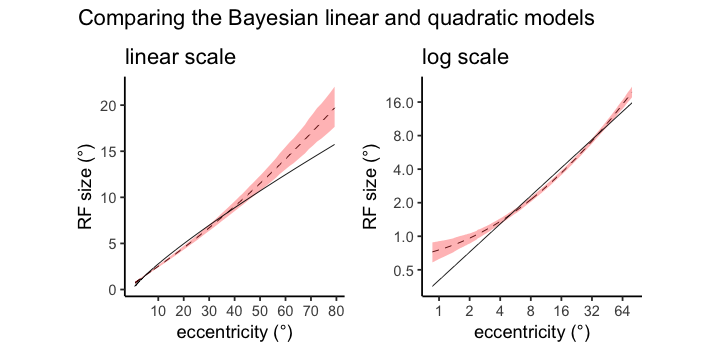

In [62]:
(tmp.g.V2.bayes +
    scale_x_continuous(
        breaks=c(10,20,30,40,50,60,70,80)) +
    scale_y_continuous(
        breaks=c(0,5,10,15,20,25,30,40)) +
    geom_line(
        data = tmp.newdf2,
        aes(x = x, y = y),
        size=0.25) +
    ggtitle("linear scale")
) + 
(tmp.g.V2.bayes.log +
    scale_x_continuous(
        breaks=c(1,2,4,8,16,32,64)) +
    scale_y_continuous(
        breaks=c(0.5,1,2,4,8,16,32)) +
    geom_line(
        data = tmp.newdf2,
        aes(x = x, y = y),
        size=0.25) +
    ggtitle("log scale")
) + 
plot_annotation(
    title = "Comparing the Bayesian linear and quadratic models",
)

The figure above shows that as in least-square regression, the quadratic model (dashed lines and pink bands) predicts larger RF at very high and very low eccentricities, compared to the linear model (solid line). I had suspected that once the uncertainty of eccentricity is taken into account, the quadratic term would become unnecessary. But that is not supported by Bayesian inferencing.

Just in least-square regression, we want to know if the additional complexity of the quadratic model is justified. Although it is possible to perform Bayesian model selection by estimating the posterior probability of each model using MCMC, we'll do something easier: The Deviance information criterion (DIC) is an index similar to AIC and BIC that can be calculated from MCMC simulations. The model with smaller DIC is the better model.

In [312]:
data.frame(
    model=c('linear', 'quadratic'),
    DIC=c(jags.V2.linear2$BUGSoutput$DIC, jags.V2.poly$BUGSoutput$DIC))

model,DIC
linear,814.6132
quadratic,767.8227


The table above suggests that it is preferable to use quadratic models to characterize the relationship between RF size and eccentricity.

## Bayesian analysis for area V6

So have, we have a developed a good characterization of area V2. Let's do the same for area V6.

In [313]:
# bundle data for JAGS
jags.Data.Desc <- list(
    x = data.V6$log2.ecc,
    y = data.V6$log2.rfsize
)

# define the Bayesian model
jags.Model.String <- "
# standardize x and y into zx and zy
data {
    N <- length(y)
    mx <- mean(x)
    my <- mean(y)
    sdx <- sd(x)
    sdy <- sd(y)
    for (i in 1:length(y)) {
        zx[i] <- (x[i] - mx) / sdx
        zy[i] <- (y[i] - my) / sdy
    }
}

model {
    # likelihood
    for (i in 1:N) {
        zy[i]  ~ dnorm(mu[i], 1/zsigma^2)
        zxn[i] ~ dnorm(zx[i], 1/zsigma^2)
        mu[i] <- zbeta0 + zbeta1 * zxn[i] + zbeta2 * pow(zxn[i], 2)
    }
    
    # priors - these are all vague prior on standardized scale
    zbeta0 ~ dnorm( 0, 1/(10)^2 )
    zbeta1 ~ dnorm( 0, 1/(10)^2 )
    zbeta2 ~ dnorm( 0, 1/(10)^2 )
    zsigma ~ dunif( 1.0E-3, 1.0E+3)

    # transform to original scale. Algebra solved by Mathematica
    beta2 <- sdy * zbeta2 / pow(sdx, 2)
    beta1 <- sdy * (sdx * zbeta1 - 2 * mx * zbeta2) / pow(sdx, 2)
    beta0 <- my + sdy * (pow(sdx, 2) * zbeta0 - mx * sdx * zbeta1 + pow(mx, 2) * zbeta2)/pow(sdx, 2)
    sigma <- zsigma * sdy
}
"
writeLines(jags.Model.String, con="tmp-jags-model5.txt")

In [314]:
jags.V6.poly = jags(
    data     = jags.Data.Desc,
    inits    = NULL,
    parameters.to.save = c('beta0', 'beta1', 'beta2', 'sigma'),
    model.file = "tmp-jags-model5.txt",
    n.chains = 3,
    n.iter   = 1000,
    n.burnin = 300
)

Compiling data graph
   Resolving undeclared variables
   Allocating nodes
   Initializing
   Reading data back into data table
Compiling model graph
   Resolving undeclared variables
   Allocating nodes
Graph information:
   Observed stochastic nodes: 387
   Unobserved stochastic nodes: 391
   Total graph size: 3520

Initializing model



In [315]:
tidyMCMC(as.mcmc(jags.V6.poly), conf.int = TRUE, conf.method = "HPDinterval")

term,estimate,std.error,conf.low,conf.high
beta0,0.9578214,0.53501772,-0.13628966,1.9595924
beta1,-0.1753177,0.27161954,-0.70470211,0.3601099
beta2,0.1376755,0.03272565,0.07254884,0.1996337
sigma,0.5384259,0.02152707,0.49671194,0.5789303


In [316]:
tmp.newdf.V6 <- data.frame(
    log2x = seq(
        min(data.V6$log2.ecc), 
        max(data.V6$log2.ecc), 
        len = 200)
)

tmp.mcmc <- jags.V6.poly$BUGSoutput$sims.matrix
tmp.X <- as.matrix(data.frame(model.matrix(~log2x, tmp.newdf.V6)) %>% mutate(log2x2=log2x^2))
tmp.coefs <- tmp.mcmc[, c("beta0", "beta1", "beta2")]
tmp.fit <- tmp.coefs %*% t(tmp.X)
tmp.newdf.V6 <- tmp.newdf.V6 %>% cbind(tidyMCMC(tmp.fit, conf.int = TRUE, conf.method = "HPDinterval"))
tmp.newdf.V6 <- tmp.newdf.V6 %>% mutate(x=2^log2x, y=2^estimate, y.low=2^conf.low, y.high=2^conf.high)

tmp.g.V6.bayes <- 
    ggplot(tmp.newdf.V6, 
           aes(x = x, y = y)) + 
    geom_ribbon(
        aes(ymin = y.low,
            ymax = y.high), 
        fill = "blue", alpha = 0.3) + 
    geom_ribbon(
        data = tmp.newdf.V2,
        aes(
            ymin = y.low,
            ymax = y.high),
        fill = "red", alpha = 0.3) +
    labs(
        x="eccentricity (°)",
        y="RF size (°)") + 
    theme_classic() +
    theme(
        aspect.ratio=1
    ) 

tmp.g.V6.bayes.log <- 
    tmp.g.V6.bayes +
    coord_trans(y='log2', x='log2')

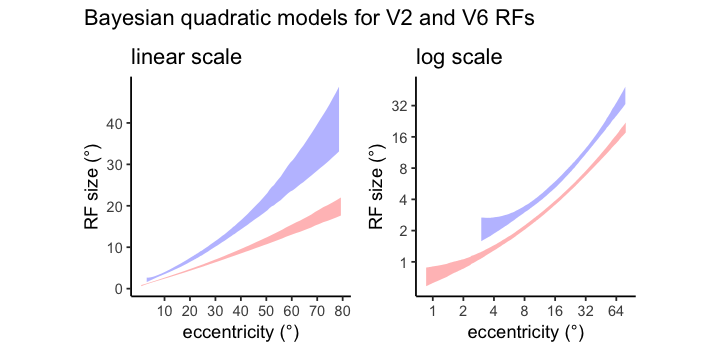

In [317]:
(tmp.g.V6.bayes +
     scale_x_continuous(
        breaks=c(10,20,30,40,50,60,70,80)) +
    scale_y_continuous(
        breaks=c(0,10,20,30,40)) +
    ggtitle("linear scale")
) +
(tmp.g.V6.bayes.log +
    scale_x_continuous(
        breaks=c(1,2,4,8,16,32,64)) +
    scale_y_continuous(
        breaks=c(0.5,1,2,4,8,16,32)) +
    ggtitle("log scale") 
) +
plot_annotation(
    title = "Bayesian quadratic models for V2 and V6 RFs",
)

The figure above compares the mean RF sizes for V2 (red) and V6 (blue). Interestingly, even though the Bayesian model allows uncertainty in eccentricity, the two curves are approximately shifted versions of each other in log-log space. This simple relationship is not what was provided by Model II regression. 

## Use hierarchical Bayesian model to decide if V2 and V6 RFs have different sizes

Judging from the figure above, the answer should be obvious. But we still want to infer it within the Bayesian framework. 
## TODO